# Model Evaluation
Will formalize into functions later

In [1]:
%load_ext autotime

In [2]:
import pandas as pd
import numpy as np
import pickle

import keras
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model

from pathlib import Path
from matplotlib import pyplot as plt
%matplotlib inline

import utils

Using TensorFlow backend.


time: 4.79 s


In [3]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 625 ms


In [6]:
x_test, y_test = utils.read_mura_pickle(sample='valid')

INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 229 ms


In [7]:
size = x_test.shape[1]
x_test = x_test.reshape(x_test.shape[0], size, size, 1)
x_test = utils.normalize_pixels(x_test)
# y_test = to_categorical(y_test)

time: 411 ms


In [40]:
with tf.device('/GPU:0'):
    model = load_model('./trained_models/2_1_submodel_335.h5')

time: 39.6 s


In [41]:
y_test_hat = model.predict(x_test)

time: 18.9 s


In [42]:
# true_label = np.argmax(y_test, axis=1)
# pred_label = np.argmax(y_test_hat, axis=1)
true_label = y_test
pred_label = np.round(y_test_hat)

time: 814 µs


In [43]:
from sklearn.metrics import confusion_matrix

class MURAMetrics():
    
    def __init__(self, true_label, pred_label):
        assert true_label.shape[0] == pred_label.shape[0], (
            'true_label and pred_laben must have the same length!')
        self.y = true_label
        self.yhat = pred_label
        self.N = true_label.shape[0]
        self.cm = confusion_matrix(true_label, pred_label)
        
    def accuracy(self):
        return (self.cm[0, 0] + self.cm[1, 1]) / self.N

    def kappa(self):
        p_observed = self.accuracy()
        p_expected = (
            self.cm[1, :].sum() * self.cm[:, 1].sum() 
            + self.cm[0, :].sum() * self.cm[:, 0].sum()) / self.N**2
        return (p_observed - p_expected) / (1 - p_expected)
    
    def precision_and_recall(self):
        return {
            'precision': self.cm[1, 1] / self.cm[:, 1].sum(),
            'recall': self.cm[1, 1] / self.cm[1, :].sum()
        }

time: 6.35 ms


In [44]:
metrics = MURAMetrics(true_label, pred_label)

time: 12 ms


In [45]:
metrics.accuracy()

0.7832342821395057

time: 2.36 ms


In [46]:
metrics.kappa()

0.5618702376952556

time: 2.23 ms


In [47]:
metrics.precision_and_recall()

{'precision': 0.8467274233637117, 'recall': 0.6679738562091503}

time: 2.17 ms


## Compute metrics by patient and study

In [48]:
with Path('./data/MURA-v1.1/valid_groups.pkl').open('rb') as pkl_file:
    valid_groups = pickle.load(pkl_file)

time: 3.7 ms


In [49]:
valid_groups['pred_label'] = pred_label

time: 1.04 ms


In [50]:
valid_groups.columns

Index([             0,    'body_part',   'patient_id',     'study_id',
       'target_label',     'image_id',   'pred_label'],
      dtype='object')

time: 3.14 ms


In [51]:
valid_grouped = valid_groups.groupby(['body_part', 'patient_id', 'study_id'])[['target_label', 'pred_label']].mean().round(0)

time: 9.54 ms


In [52]:
grouped_metrics = MURAMetrics(valid_grouped['target_label'], valid_grouped['pred_label'])

time: 4.95 ms


In [53]:
grouped_metrics.accuracy()

0.7956630525437864

time: 1.69 ms


In [54]:
grouped_metrics.kappa()

0.5756034274767361

time: 1.95 ms


In [55]:
grouped_metrics.precision_and_recall()

{'precision': 0.8825065274151436, 'recall': 0.6282527881040892}

time: 1.79 ms


In [56]:
valid_grouped = valid_groups.groupby(['body_part', 'patient_id', 'study_id'])[['target_label', 'pred_label']].max()

time: 8.11 ms


In [57]:
grouped_metrics = MURAMetrics(valid_grouped['target_label'], valid_grouped['pred_label'])

time: 11.6 ms


In [58]:
grouped_metrics.accuracy()

0.780650542118432

time: 2.28 ms


In [59]:
grouped_metrics.kappa()

0.5571712842491964

time: 2.39 ms


In [60]:
grouped_metrics.precision_and_recall()

{'precision': 0.7522935779816514, 'recall': 0.7620817843866171}

time: 1.92 ms


[[1482  185]
 [ 508 1022]]


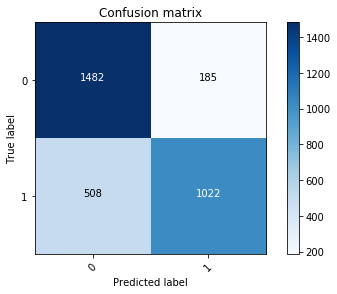

time: 171 ms


In [61]:
utils.plot_confusion_matrix(pred_label=pred_label, true_label=true_label, classes=['0', '1'])